In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
path = './data/'
p1= pd.read_csv(path+'users.csv')
p2= pd.read_csv(path+'books.csv')
p3= pd.read_csv(path+'train_ratings.csv')
p4= pd.read_csv(path+'sample_submission.csv')
p5= pd.read_csv(path+'test_ratings.csv') # test와 sample은 완벽하게 동일하다.
users  =p1
books  =p2
train  =p3
sample =p4
test   =p5

print('users shape: ', users.shape) 
print(users.columns)#유저id, 지역, 나이
print('books shape: ', books.shape)
print(books.columns)#isbn(책번호), 제목, 저자, 출판년도, 출판사, img주소, 언어, 범주, 요약, img경로
print('train shape: ', train.shape) 
print(train.columns)# 유저 id, 책isbn, 평점

users shape:  (68092, 3)
Index(['user_id', 'location', 'age'], dtype='object')
books shape:  (149570, 10)
Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_url', 'language', 'category', 'summary', 'img_path'],
      dtype='object')
train shape:  (306795, 3)
Index(['user_id', 'isbn', 'rating'], dtype='object')


In [2]:
print(users.nunique()) 
#유저 자체는 중복이 없고, 지역과 나이는 중복이 많다.
print(users.info())
# 지역에 0에 결측이 없다는 듯 말하지만 밑에 돌려보면 있다.
# 나이는 2만 정도 결측.
print(users.describe())
#id에 평균이니 뭐니는 쓸모 없다...만 최소가 0이 아니니 번호 내에 빈 값이 존재하긴 한다.
#평균 나이는 36. 이후에 그래프로 보면 더 나을 듯. 5살과 99살도 있으니 연령대는 다양.

user_id     68092
location    18368
age            91
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB
None
             user_id           age
count   68092.000000  40259.000000
mean   139381.329539     36.069873
std     80523.969862     13.842571
min         8.000000      5.000000
25%     69008.750000     25.000000
50%    138845.500000     34.000000
75%    209388.250000     45.000000
max    278854.000000     99.000000


In [7]:
train.sample(10)

,user_id,isbn,rating
11128,108243,0439139597,9
36773,225595,0061056871,7
237796,70245,0525473386,10
172636,19760,0743400518,8
107109,189835,0140042407,2
3230,130258,0316735736,9
59509,23768,0151006725,7
57729,198711,0553269828,8
203779,252347,0380798913,7
107218,54997,3423202327,8


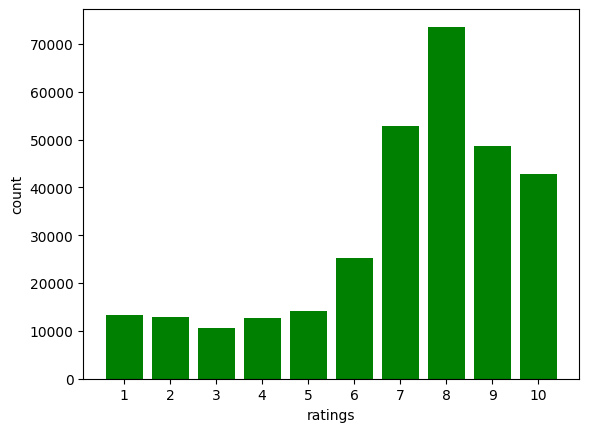

In [8]:
fig, ax = plt.subplots(1,1)

tmp = train['rating'].value_counts().sort_index()
ax.bar(tmp.index, tmp.values, color='green')
ax.set_xticks(tmp.index)
ax.set_xlabel('ratings')
ax.set_ylabel('count')

plt.show()

8점을 준 사람이 굉장히 많다. 전반적으로 낮은 평점을 준 사람이 적은데, 이 사람들의 값을 이상치로 간주하고 생각을 해볼 수도 있다. 물론 한 사람이 다채롭게 평점을 줄 수 있으니 그러한 점도 고려해야 한다. 

In [9]:
#series.loc[i:j] 이렇게 쓰라는데 뭐라는 거냐.
print(train['user_id'].value_counts().iloc[:10].to_dict())
train['user_id'].value_counts().iloc[:10].sum()/len(train)
#수상할 정도로 책을 많이 읽은 사람들이 있다. 이 사람들은 뭔가 이상하다.
#이 사람들의 평점을 알아보자

{11676: 5520, 98391: 4560, 189835: 1503, 153662: 1496, 23902: 956, 235105: 812, 76499: 810, 171118: 771, 16795: 760, 248718: 747}


0.05845923173454587

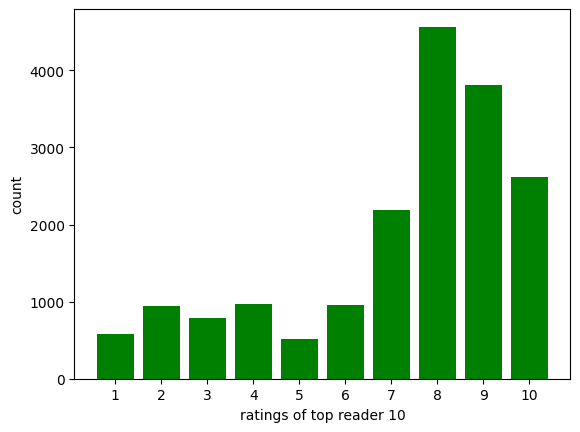

In [10]:
fig, ax = plt.subplots(1,1)

top_n = 10
tmp = train['user_id'].value_counts().iloc[:top_n].to_dict()
tmp = train[train['user_id'].isin(tmp.keys())]['rating'].value_counts().sort_index()
ax.bar(tmp.index, tmp.values, color='green')


ax.set_xticks(tmp.index)
ax.set_xlabel(f'ratings of top reader {top_n}')
ax.set_ylabel('count')

plt.show()
#상위 5명이 주는 평점. 겉으로 봤을 때는, 전체적인 그림과 조금 다르다
#그러나 5퍼센트 정도에 해당하는 값이며 어마무시하게 차이가 나는 것도 아니기에, 모델이 알아서 학습하도록 내버려두는 것도 괜찮을 것 같다.


In [64]:
#혹시 모르니 평균으로도 확인해보자. 

print(train['rating'].describe()[:3])

top_n = 10
tmp = train['user_id'].value_counts().index[:top_n]
tmp = train[train['user_id'].isin(tmp)]['rating']
print(tmp.describe()[:3])
#역시나 유의미한 특이점은 관찰되지 않는다.

count    306795.000000
mean          7.069714
std           2.433217
Name: rating, dtype: float64
count    17935.000000
mean         7.211319
std          2.494838
Name: rating, dtype: float64


In [13]:
# books.drop('img_path', axis=1, inplace=True)
books.fillna('1', inplace=True)
books.loc[books[books['category'].notnull()].index, 'category'] = \
	books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
books['category'] = books['category'].str.lower()

In [47]:
# 내용물을 들여다 보는 코드
(books[books['category'].str.contains('onto') \
	# & (books['category'] != '') \
	# & (books['category'] != 'self help') \
	# & (books['category'].str.contains('men') == True) \
	& (books['category'].str.contains('comic') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
89114,363087147X,Die groÃ?Â?e Liebe.,Hanns-Josef Ortheil,2003.0,Luchterhand Literaturverlag,de,san benedetto del tronto fernsehredakteur deut...,Ein deutscher TV-Redakteur und eine Meeresbiol...,others
147511,0135774780,The messenger's motives: Ethical problems of t...,John L Hulteng,1976.0,Prentice-Hall,en,journalistes déontologie,Examines more than 150 cases involving news me...,others


In [25]:
lst = {'juvenile':['juvenile', 'young adult'],
	'fiction':['fiction', 'businessmen', 'businesswomen'],
	'religion':['religion', 'christian', 'budd', 'arab', 'cath', 'bible', 'muslim', 'hind', 'church', 'pray', 'monk'],
	'biography':['biography'],
	'humor':['humor', 'fun', 'wit '],
	'meditation':['spirit', 'self', 'help'],
	'social':['soci', 'discrimination'],
	'politic':['policy', 'polit'],
	'computer':['comput'],
	'science':['science'],
	'economy':['business', 'economi'],
	'family':['family'],
	'health':['health', 'body'],
	'animal':['animal', 'pets', 'pet ', 'dog', 'cats', 'bird', 'insect', 'tiger', 'fish', 'amphibian', 'reptil', 'mamma', 'panda', 'bear', 'chick'],
	'nature':['nature', 'environ', 'plant', 'earth'],
	'history':['histo', 'folk'],
	'art':['art', 'music', 'draw'],
	'children':['child'],
	'poetry':['poet'],
	'drama':['drama', 'comedy', 'tragedy'],
	'literature':['litera'],
	'philosophy':['philo', 'ethic'],
	'cook':['cook', 'food'],
	'crime':['crim', 'homi', 'murder'],
	'photo':['photo'],
	'crafts':['craft', 'hand'],
	'garden':['garden'],
	'sports':['sports'],
	'travel':['travel'],
	'adventure':['adventure'],
	'psychology':['psycho'],
	'comic':['comic'],
	'education':['educ'],
	'mystery':['myster', 'detect'],
	'horror':['horror'],
	'law':['law'],
	'game':['game'],
	# 'country':['brita', 'engla', 'canada', 'africa', 'gree', 'asia', 'europ', 'nethe', 'korea','norwa', 'zeala', 'denmark', 'german', 'deutsch', 'russ', 'roman', 'mala', 'mexi','mong', 'viet', 'belg', 'braz', 'spain', 'singap', 'argen', 'irelan', 'austr','iran', 'isra', 'egyp', 'ital', 'india', 'indo', 'japan', 'china', 'chinese', 'portu','polan', 'fran', 'finlan', 'hunga']
	# 'america':['united', 'ameri']
	}

In [39]:
books['high_category'] = books['category'].copy()
# books.drop('high_catgory', axis=1, inplace=True)

In [41]:
for i in lst:
	tmp = '|'.join(lst[i])
	books['high_category'].where(books['category'].str.contains(tmp)==False, i, inplace=True)

In [42]:
books['high_category'].value_counts()

1                                       68851
fiction                                 41067
biography                                3351
science                                  2429
religion                                 2133
                                        ...  
gulliver lemuel fictitious character        1
civilization western                        1
mathematicians                              1
tyrol austria                               1
deafness                                    1
Name: high_category, Length: 2964, dtype: int64

In [43]:
category_high_df = pd.DataFrame(books['high_category'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
others_list = category_high_df[category_high_df['count']<5]['category'].values
books['high_category'].where(books['high_category'].isin(others_list) == False, 'others', inplace=True)

In [45]:
books['high_category'].value_counts()

1                  68851
fiction            41067
others              3784
biography           3351
science             2429
                   ...  
cruise ships           5
missing persons        5
success                5
abduction              5
ethics                 5
Name: high_category, Length: 373, dtype: int64

In [49]:
#이제 오랜 시간은 그만. 그냥 파일로 저장하자.
!rm /opt/ml/input/code/books_clustering.csv
if not os.path.isfile('/opt/ml/input/code/books_clustering.csv'):
	print('saving')
	books.to_csv('/opt/ml/input/code/books_clustering.csv', index=False)

saving
